In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Importujemy dataset

In [ ]:
data = pd.read_csv("Breast_cancer_data.csv")
data.head(20)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


<Axes: >

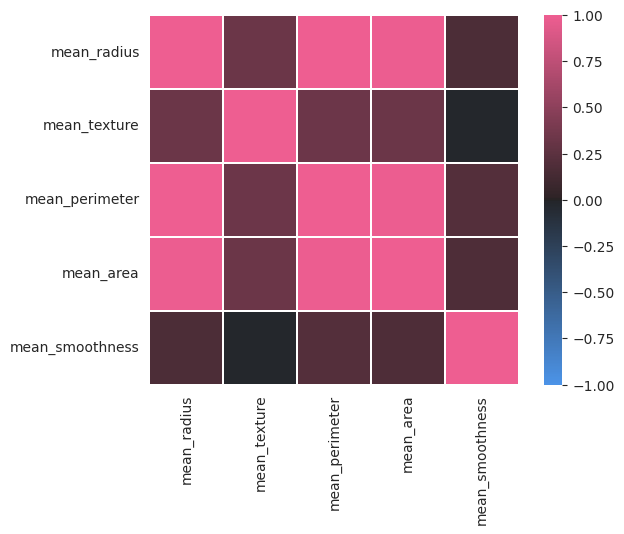

In [ ]:
#sprawdzamy skorelowanie zmiennych i niezależność zmiennych
corr = data.iloc[:,:-1].corr(method="pearson") #bierzemy wszystkie wiersze i wszystkie kolumny poza ostatnią ("diagnosis")
cmap = sns.diverging_palette(250,354,80,60,center="dark", as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-1, cmap=cmap, square=True, linewidth=.2)


In [ ]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


<Axes: xlabel='mean_texture', ylabel='Count'>

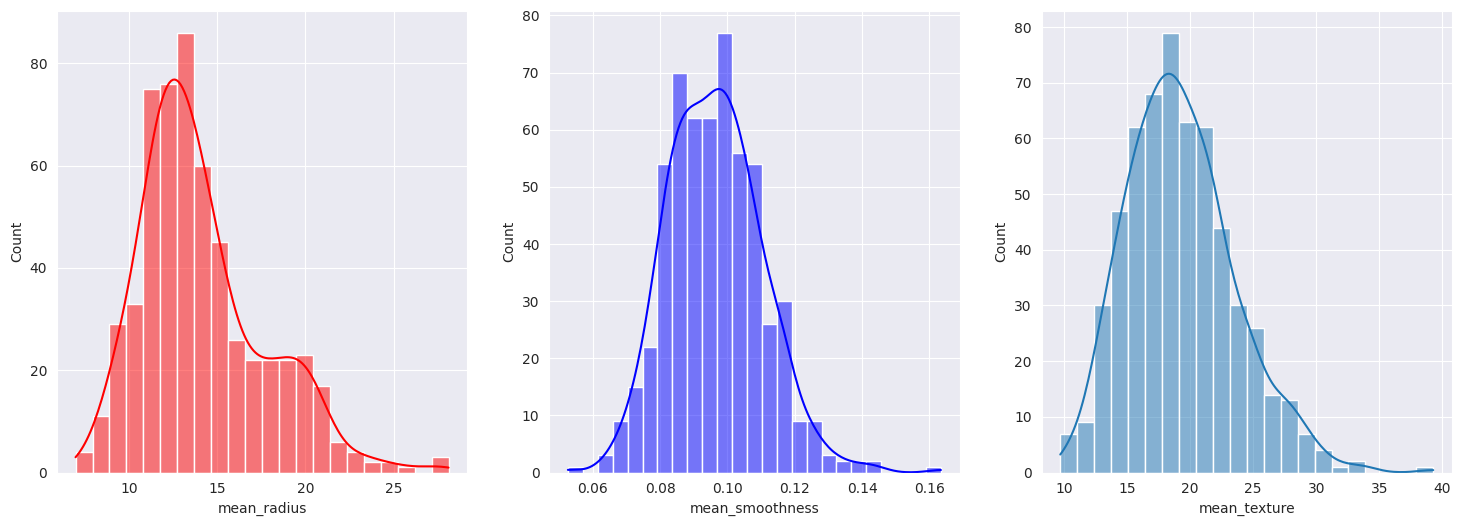

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

In [ ]:
 #liczymy prawdopodobieństwo P(Y=y) dla każdego możliwego y
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique())) #sprawdzamy występujące klasy, w naszym przypadku to 0 i 1
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df)) #liczymy prawdopodobieństwo wystąpienia każdej z klas
    return prior

Sposób 1: Korzystamy z rozkładu normalnego

In [ ]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std() #liczymy średnią i odchylenie dla danej cechy
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 ))) #korzystamy z rozkładu normalnego
    return p_x_given_y

Liczymy jaka klasa maksymalizuje nam P(Y|X)

In [ ]:
def naive_bayes_gaussian(df, X, Y):

    features = list(df.columns)[:-1]

    prior = calculate_prior(df, Y) #nasza funkcja, która liczy P(Y) dla każdej z występujących klas

    Y_pred = [] #lista, która przetrzymie nam przewidzianą klasę

    for x in X: #loopujemy po każdym data sample
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)): #idziemy przez każdą klasę
            for i in range(len(features)): #w każdej klasie idziemy przez każdą cechę
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j] #liczymy wcześniej wspominany licznik, czyli P(Y|X) = P(X|Y)P(Y)

        Y_pred.append(np.argmax(post_prob)) #bierzemy tą klasę, która maksymalizuje P(Y|X)
    return np.array(Y_pred)

Testujemy model : ))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

train, test = train_test_split(data, test_size=.2, random_state=41) #splitujemy dane na set treningowy i testowy

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

Y_pred = naive_bayes_gaussian(train, X=X_test, Y='diagnosis')

print(confusion_matrix(Y_test, Y_pred)) #0 false negatives, 4 false positives, porównujemy Y_test z Y_pred
print(f1_score(Y_test, Y_pred))  #F1 - średnia ważona precyzji i pełności, która uwzględnia fałszywe pozytywy i negatywy

[[36  4]
 [ 0 74]]
0.9736842105263158


Sposób 2: Zamieniamy zmienne ciągłe na kategoryczne

In [ ]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


In [ ]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

In [ ]:
def naive_bayes_categorical(df, X, Y):
    features = list(df.columns)[:-1]

    prior = calculate_prior(df, Y)

    Y_pred = []

    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345
